#Testing rate theories for a simple barrier crossing problem

In [60]:
%load_ext autoreload
%matplotlib inline
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fitter
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
colors = ['orange', 'red', 'blue', 'cyan']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we summarize the procedure used for estimating the rates for crossing a barrier for a simple system: a small Lennard-Jones particle in water experiencing the influence of an underlying potential. 

## Results from molecular dynamics simulations
We run molecular dynamics (MD) simulations of a Lennard-Jones particle with parameters corresponding to a C$^\alpha$ atom, in a box of TIP3P water. The particle is under the influence of a one dimensional potential of the form

$V(x)=V_0 \cos(2\pi nx/l)$

In this expression $V_0$ is half the energy barrier height 
($\Delta G_{b\ddagger}=2V_0$) and $n$ is the number of periods within the 
box length ($l=32~Å$). In the simulations the water masses were scaled so that we produce different viscosity conditions in the solvent.

The kinetics were calculated using a Markov state model in this case for the two-state system. Below we show a plot of the relaxation times from the MSM as a function of the solvent viscosity. In the plots we also show linear and power law fits (blue and green, respectively). 

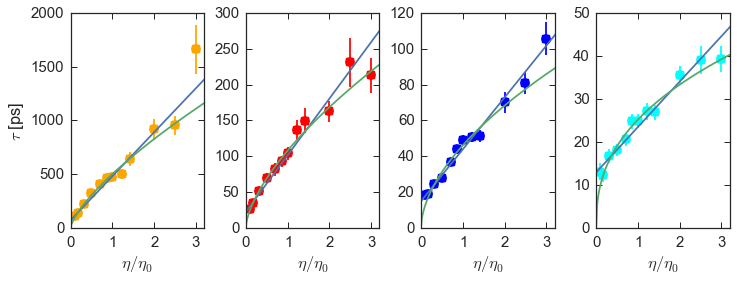

In [61]:
fig, ax = plt.subplots(1,4, figsize=(10,4))
k = 0
for bump in [2, 4, 6, 8]:
    filename = "data/tau_vs_visc_bumpy%g.dat"%bump
    data = [(float(x.split()[0]),float(x.split()[1]),float(x.split()[2])) \
            for x in open(filename).readlines()]
    data = np.array(data)
    ax[k].errorbar(data[:,0],data[:,1],data[:,2], fmt='o', \
                markersize=10, label=bump, color=colors[k])
    filename = "data/fits_bumpy%g_10kJ.dat"%bump
    data = [(float(x.split()[0]),float(x.split()[1]),float(x.split()[2])) \
            for x in open(filename).readlines()]
    data = np.array(data)
    ax[k].plot(data[:,0],data[:,1])
    ax[k].plot(data[:,0],data[:,2])
    ax[k].set_xlim(0,3.2)
    ax[k].xaxis.set_ticks(range(0,4,1))
    ax[k].set_xlabel(r'$\eta/\eta_0$')
    k +=1
plt.tight_layout()
_ = ax[0].set_ylabel(r'$\tau$ [ps]')

Here we already see that the viscosity dependence of the relaxation times is very different in the case of the broadest barrier (left) compared to the narrowest barrier (right). This difference appears not in the timescales, but most importantly in the curvatures. Below we show all the data plotted together and normalized by the characteristic time at $\eta=\eta_0$. The dashed line marks the zero internal friction behaviour.

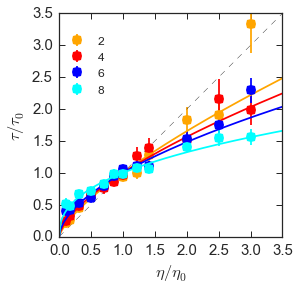

In [62]:
fig, ax = plt.subplots(figsize=(4,4))
k = 0
ax.plot([0,4],[0,4], '--', color='k', linewidth=0.4)
for bump in [2, 4, 6, 8]:
    filename = "data/eta_vs_tau_norm_bumpy%g_10kJ.dat"%bump
    data = [(float(x.split()[0]),float(x.split()[1]),float(x.split()[2])) \
            for x in open(filename).readlines()]
    data = np.array(data)
    ax.errorbar(data[:,0],data[:,1],data[:,2], fmt='o', \
                markersize=10, label=bump, color=colors[k])
    filename = "data/fits_bumpy%g_10kJ_norm.dat"%bump
    data = [(float(x.split()[0]),float(x.split()[1]),float(x.split()[2])) \
            for x in open(filename).readlines()]
    data = np.array(data)
    ax.plot(data[:,0],data[:,2], color=colors[k])
    k +=1
ax.set_xlim(0,3.5)
ax.set_ylim(0,3.5)
ax.set_xlabel(r'$\eta/\eta_0$')
ax.set_ylabel(r'$\tau/\tau_0$')
_ = ax.legend(fontsize=12, bbox_to_anchor=(0.25, 0.95))

##Results for different rate theories

###Transition state theory
We start by transition state theory (TST), which is neccesarily an upper bound to the true rate, since every time that the particle reaches the barrier it will cross it. The TST rate can be calculated as

$k^{TST}=(\omega_b/2\pi)\exp(-\beta\Delta G_{b\ddagger})$

where $\omega_b$ is the frequency at the bottom of the reactant well and $\Delta G_{b\ddagger}$ is the energy barrier (in this case, $\Delta G_{b\ddagger}=2V_0$).

Approximating the potential locally as a parabola of the form $V_{\mathrm{max}} - 1/2 k(x-x_0)^2$ we obtain the spring constant $k = V''$. The second derivative of our potential, 

$V(x)=-V_0(2\pi n/l)^2\cos(2\pi x/l)$

at the barrier top has a value of $V''(0)=-V_0(2\pi n/l)^2$. Hence we 
can calculate the barrier frequency, $\omega_\ddagger=\sqrt{k/m}$. Substituting we find that 

$	\omega_\ddagger = (2\pi n/l)\sqrt{V_0/m}$

using the particle mass $m$=12.01 g/mol. The resulting values are calculated below. 

In [63]:
def frequency(n, V0, lbox, m):
    """ 
    Calculates frequency based on parameters.
    
    Parameters
    ----------
    V0 : float
        Potential.
    
    n : int
        Number of periods.
        
    lbox : float
        Box length in nm.
        
    Returns
    -------
    const : float
        Force constant.
        
    omega : float
        Frequency of the well.
        
    """
    const = V0*(2.*math.pi*n/lbox)**2
    omega = math.sqrt(const/m*1.e-3)
    return const, omega

# define parameters from the simulations
viscosities = [0.1, 0.173205, 0.316228, 0.5, 0.707107, 0.866025,\
           1, 1.22474, 1.41421, 2, 2.5, 3]
lvisc = len(viscosities)
mass = 12e-3 # in kg/mol
beta = 1./(8.314e-3*300) # in (kJ/mol)^-1
lbox = 3.2 # in nm
barrier = 10 
V0 = barrier/2. # amplitude in kJ/mol

# calculate barrier dependent term
tst_exp = 1./(2.*math.pi)*math.exp(-beta*2.*V0)
periods = [2, 4, 6, 8]

# calculate barrier frequency
print " Barrier frequencies and transition state theory rates"
print "  n  k [kJ/(mol*nm**2)] omega [ps-1] ktst [ps-1]"
ktst = []
omega = []
for prd in periods:
    # calculate frequency of the potential
    k, om = frequency(prd, V0, lbox, mass)
    omega.append(om)
    ktst.append(om*tst_exp)
    print " %2i  %12.4f   %12.4f   %12.4e "%(prd, k, om, ktst[-1])

 Barrier frequencies and transition state theory rates
  n  k [kJ/(mol*nm**2)] omega [ps-1] ktst [ps-1]
  2       77.1063         2.5349     7.3208e-03 
  4      308.4251         5.0697     1.4642e-02 
  6      693.9566         7.6046     2.1962e-02 
  8     1233.7006        10.1394     2.9283e-02 


The results seem sensible based on the energy barrier heights, as it will result in barrier crossing times between the tens and hundreds of 
picoseconds.

###Kramers rate theory
Next we calculate the Kramers rate using the high and intermediate friction rate expressions. In the high friction regime the rate expression is

$k_{\mathrm{K}}=
		(\omega_b\omega_\ddagger/2\pi\gamma)\exp(-\beta\Delta G)$
        
where $\gamma$ is the friction coefficient and $\omega_b$ is the frequency at the bottom of the well (which in our case is conveniently equal to that at the top of the barrier, $\omega_b=\omega_\ddagger$). At intermediate friction we must use 

$k_{\mathrm{K}}=
	\big([(\gamma/4)^2+\omega_\ddagger^2]^{1/2}-\gamma/2\big)/\omega_\ddagger
    (\omega_b/2\pi)\exp(-\beta\Delta G_\ddagger).$

All of the terms in Kramers rate expressions can be calculated from the simulation data itself. We obtain the friction coefficient as

$\gamma = \zeta_0/m = m^{-1}\int_0^\infty\zeta(t)dt$

where we are using the memory friction $\zeta(t)$, defined as 

$\zeta(t) = \beta <F_x(\tau)F_x(\tau+t)>_\tau$

In brackets we show the autocorrelation function of the x component of the solvent forces on the particle (i.e. the contribution corresponding to the reaction coordinate for the barrier crossing problem we are studying).


First we read the autocorrelation functions and fit them to a functional form that captures well their shape.

In [64]:
# read acf
facf = []
path_facf = "data/LJ_tip3pTRUE_freeze_n"
for i in range(lvisc):
    file_facf = path_facf + "%g_force_acf_select.dat"%i
    data = np.array([[float(x.split()[0]), float(x.split()[1]), \
            float(x.split()[2])] for x in open(file_facf).readlines()])
    facf.append(data)

Instead of fitting all of the autocorrelation functions we simply fit the ACF at the lowest viscosity and scale the fit. This approach captures very well the results.

8649.85
 fitting data to expsq
      number of parameters: 1
     initial parameters: [ 0.03714864]
     fitted parameters: [ 11108.26302977]
     R**2: 0.94282 

 fitting data to exp1_expsq
      number of parameters: 3
     initial parameters: [0.0, 0.0, 11108.263029768103]
     fitted parameters: [  5.98217642e-01   4.09547374e+01   2.13785404e+04]
     R**2: 0.991582 

 fitting data to exp2_expsq
      number of parameters: 5
     initial parameters: [0.59821764224063834, 0.0, 0.0, 40.954737380188234, 21378.54044181748]
     fitted parameters: [  1.08561896e-01   8.64588162e-01   3.92487702e+00   7.16652618e+01
   2.05111703e+04]
     R**2: 0.995182 

 Best fit to data: exp2_expsq



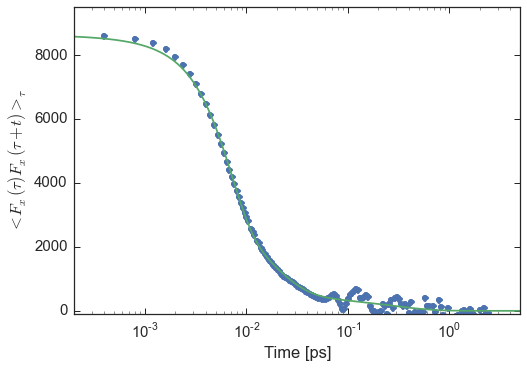

In [65]:
# select data sets to fit 
eta0 = viscosities[0]
time = facf[0][:,0] # in ps
acfraw = facf[0][:,1] # force acf
#f2mean = acfraw[0] # mean squared force
f2mean = np.mean([x[0,1] for x in facf])
print f2mean
acf = facf[0][:,2] # normalized force acf
# do fits of normalized results to several functional forms
bestfit = fitter.do_fits(time,acf)
# scale fit to recover data
tsim = np.logspace(-6, 4, 1000000)

fig, ax = plt.subplots()
ax.plot(time, f2mean*acf,'o')
ax.plot(tsim, f2mean*bestfit(tsim))
ax.set_xscale('log')
ax.set_xlabel('Time [ps]')
ax.set_ylabel(r'$<F_x(\tau)F_x(\tau+t)>_\tau$')
ax.set_xlim(2e-4,5)
_ = ax.set_ylim(-100,1.1*f2mean)

Below I show the normalized ACFs, with the green line corresponding to the scaled fit.

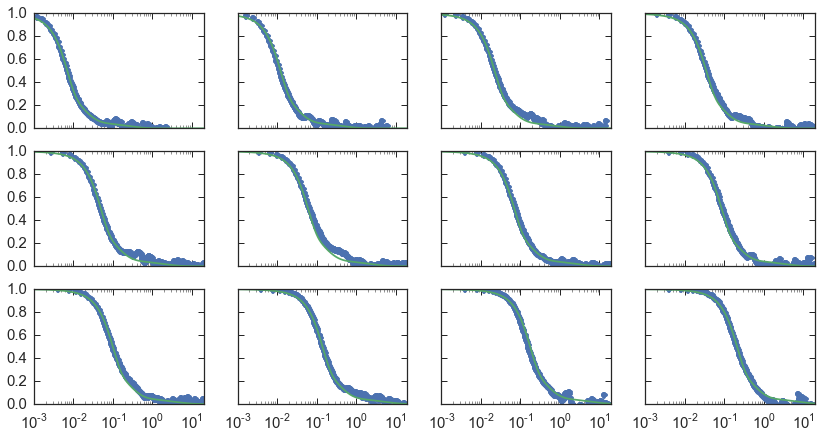

In [66]:
k = 0
fig, ax = \
    plt.subplots(3,4, figsize=(14,7), sharex=True, sharey=True)
fig.set_facecolor("white")
ax = ax.ravel()
k = 0
for eta in viscosities:
    time = facf[k][:,0] # in ps
    acf = facf[k][:,2]
    ax[k].plot(time, acf, 'o')
    scaledfit = copy.deepcopy(bestfit)
    scaledfit.scale(eta0/eta)
    ax[k].plot(tsim, scaledfit(tsim))
    ax[k].set_xlim(1e-3, 20)
    ax[k].set_ylim(0, 1)
    ax[k].set_xscale('log')
    #fout = open("analysis/grotehynes/scaledfit%g.dat"%sc[1],"w")
    #for i in range(len(tsim)):
    #    fout.write("%10.6e %10.6e \n"%(tsim[i],scaledfit(tsim[i])))
    #fout.close()
    k +=1

Next we calculate the damping constant from friction kernel, which as we have seen we need for calculating Kramers' rate.

In [67]:
scaling = np.logspace(-3, 1, 50)
#scaling = viscosities
lsc = len(scaling)
gamma_zeta = np.zeros((lsc), float)
for l in range(lsc):
    sc = scaling[l]
    scaledfit = copy.deepcopy(bestfit)
    scaledfit.scale(eta0/sc)
    gamma_zeta[l] = beta/mass*f2mean*scaledfit.integrate()*1e-3
    print scaledfit.integrate(), scaledfit.laplace(0)
#    diff_gamma = 1e-5/(beta*mass*gamma_zeta[l]) # recovering cm^2/s

0.00501108715732 0.000232684773817
0.00502214538613 0.000280802272631
0.00503985772653 0.000338870116086
0.00506605723188 0.000408945962225
0.00510259263686 0.000493512977632
0.00515140607148 0.000595567829467
0.00521465580168 0.000718726873602
0.00529485439337 0.000867354301693
0.00539501049017 0.00104671678811
0.00551877938635 0.00126317011672
0.00567066044946 0.00152438440074
0.00585636487486 0.00183961587632
0.00608357961844 0.00222003490114
0.0063632482386 0.00267912178066
0.00671102272076 0.00323314444828
0.00714813290911 0.00390173492631
0.00770122291085 0.00470858499479
0.00840154837644 0.00568228571954
0.00928441701177 0.00685734058835
0.0103894936479 0.00827538815638
0.0117621102186 0.00998667752555
0.0134572471315 0.0120518489423
0.0155571081914 0.0145440826096
0.0182021193966 0.0175516918582
0.0215736884881 0.0211812525652
0.0258202738555 0.0255613797152
0.0310468456484 0.0308472849249
0.0373904688294 0.0372262764311
0.0450605571324 0.0449243964354
0.0543273397911 0.0542144

The next function corresponds to the Kramers rate calculation in both the intermediate and strong friction regimes.

In [68]:
def kramers(omega, gamma, ktst, option=None):
    """ Calculates Kramers rates.
    
    Parameters:
    ----------
    omega : float
        Barrier / well frequency
        
    gamma : float
        Friction coefficient.
        
    ktst : float
        Transition state theory rate.

    Returns:
    --------
    float
    
    """
    if option == "strong":
        return omega/gamma*ktst
    elif option == "inter":
        return (math.sqrt(1. + (gamma/(2*omega))**2) - \
                    gamma/(2*omega))*ktst

In [69]:
lprd = len(periods)
for l in range(lsc):
    # use friction kernel result to calculate Kramers
    kKZ = np.zeros((lprd, lsc), float)
    kKZinter = np.zeros((lprd, lsc), float)
    for n in range(lprd):
        for l in range(lsc):
            kKZ[n,l] = kramers(omega[n], gamma_zeta[l], ktst[n], option="strong")
            kKZinter[n,l] = kramers(omega[n], gamma_zeta[l], ktst[n], option="inter")

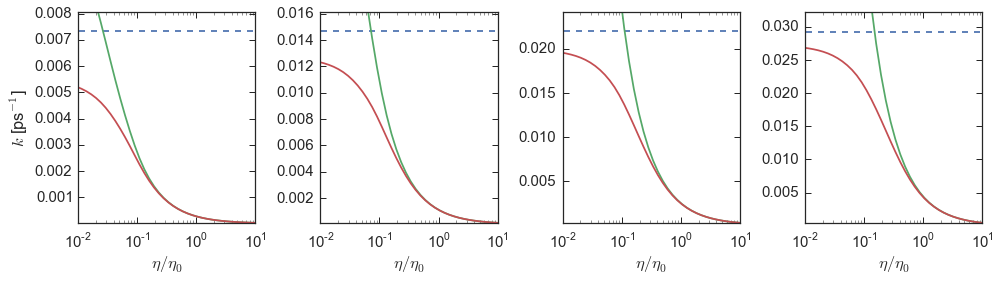

In [70]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, kKZ[i,:], scaling, kKZinter[i,:])
    ax[i].set_xlim(1e-2,10)
    ax[i].set_ylim(np.min(kKZ[i,:]),1.1*ktst[i])
    #ax[i].xaxis.set_ticks(range(0,4,1))
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
ax[0].set_ylabel(r'$k$ [ps$^{-1}$]')
plt.tight_layout()

The Kramers rate estimate seems sensible. For broad barriers the result is further appart from the TST rate, as one would expect. The more time spent in the barrier region, the more likely there will be recrossings that slow down the rate.

### Grote-Hynes calculation
We finish up by doing the self-consistent Grote-Hynes calculation. For this we need the fitted function, whose Laplace transform is used to obtain the reactive frequency.

In [71]:
kGH = np.zeros((lprd, lsc), float)
for n in range(lprd):
    # open file for output
    prd = periods[n]
    # self consistently calculate lambda
    for l in range(lsc):
        sc = scaling[l]
        scaledfit = copy.deepcopy(bestfit)
        scaledfit.scale(eta0/sc)
        lmbd = omega[n]
        diff = 1e20
        while (abs(diff/lmbd)>1e-4 and n < 1e6):
            Lzeta = beta/mass*f2mean*scaledfit.laplace(lmbd)*1e-3 # ps-1
            lmbd_new = (omega[n]**2)/(lmbd + Lzeta) # Eq 4.27 in Grote & Hynes, JCP 1981
            diff = abs(lmbd - lmbd_new)
            lmbd = lmbd_new
            # Grote-Hynes
        kGH[n,l] = lmbd/omega[n]*ktst[n]

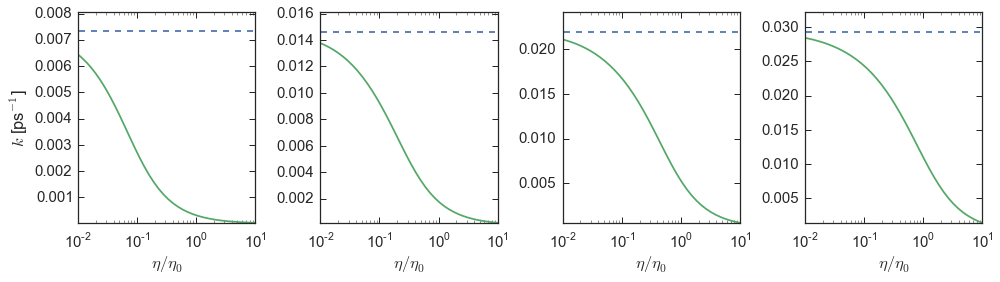

In [72]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, kGH[i,:],'-')
    #ax[i].set_xlim(0,3.2)
    ax[i].set_ylim(np.min(kGH[i,:]),1.1*ktst[i])
    ax[i].xaxis.set_ticks(range(0,4,1))
    ax[i].set_xlim(1e-2,10)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
#    ax[i].set_yscale('log')
ax[0].set_ylabel(r'$k$ [ps$^{-1}$]')
plt.tight_layout()

We finally put it all together in combination with the simulation results. We find that the Kramers rate theory captures the results well in the broad barrier case (n=2, orange), while it gradually deteriorates as the barrier becomes narrower. In that case the Kramers and Grote-Hynes theories depart from each other as in the latter the particle experiences only the fast part of the solvent friction.

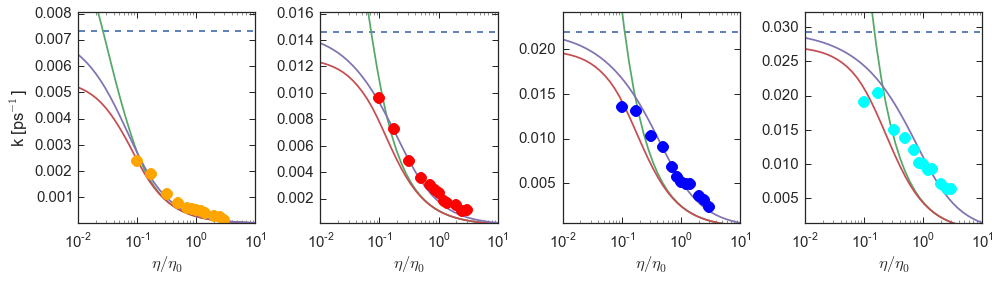

In [73]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, kKZ[i,:])
    ax[i].plot(scaling, kKZinter[i,:])
    ax[i].plot(scaling, kGH[i,:])
    ax[i].set_ylim(np.min(kGH[i,:]),1.1*ktst[i])
    ax[i].set_xlim(1e-2,10)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
#   ax[i].set_yscale('log')
    filename = "data/tau_vs_visc_bumpy%g.dat"%periods[i]
    data = [(float(x.split()[0]),float(x.split()[1]),float(x.split()[2])) \
            for x in open(filename).readlines()]
    data = np.array(data)
    ax[i].plot(data[:,0],1./(4*data[:,1]),'o', color=colors[i],markersize=12)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
ax[0].set_ylabel(r'k [ps$^{-1}$]')
_  = plt.tight_layout()

###Extending the range of viscosities
What would happen if instead of propagating up to 10 we extended the plot to larger viscosities. Would the power law be the same or would a linear fit express the results better? For that we play with the scaling of the fit.

In [101]:
scaling = np.logspace(-3, 3, 50)

In [87]:
#scaling = viscosities
lsc = len(scaling)
gamma_zeta = np.zeros((lsc), float)
for l in range(lsc):
    sc = scaling[l]
    scaledfit = copy.deepcopy(bestfit)
    scaledfit.scale(eta0/sc)
    gamma_zeta[l] = beta/mass*f2mean*scaledfit.integrate()*1e-3
    print sc, scaledfit.integrate(), scaledfit.laplace(0)
#    diff_gamma = 1e-5/(beta*mass*gamma_zeta[l]) # recovering cm^2/s

0.001 0.00501108715732 0.000232684773817
0.00132571136559 0.00503005516959 0.000308472849249
0.00175751062485 0.00506605723188 0.000408945962225
0.00232995181052 0.00512533636533 0.000542144310034
0.00308884359648 0.00521465580168 0.000718726873602
0.00409491506238 0.00534222636584 0.000952824385089
0.00542867543932 0.00551877938635 0.00126317011672
0.00719685673001 0.00575886329014 0.00167459898042
0.0095409547635 0.00608357961844 0.00222003490114
0.0126485521686 0.00652742921334 0.00294312550045
0.0167683293681 0.00714813290911 0.00390173492631
0.0222299648253 0.00803086809025 0.00517257433732
0.0294705170255 0.00928441701177 0.00685734058835
0.0390693993705 0.0110392423036 0.0090908543557
0.0517947467923 0.0134572471315 0.0120518489423
0.0686648845004 0.0168002675774 0.0159772731191
0.0910298177992 0.0215736884881 0.0211812525652
0.120679264064 0.0283041467231 0.0280802272631
0.159985871961 0.0373904688294 0.0372262764311
0.212095088792 0.049475292685 0.0493512977632
0.281176869797 

In [88]:
lprd = len(periods)
for l in range(lsc):
    # use friction kernel result to calculate Kramers
    kKZ = np.zeros((lprd, lsc), float)
    kKZinter = np.zeros((lprd, lsc), float)
    for n in range(lprd):
        for l in range(lsc):
            kKZ[n,l] = kramers(omega[n], gamma_zeta[l], ktst[n], option="strong")
            kKZinter[n,l] = kramers(omega[n], gamma_zeta[l], ktst[n], option="inter")

In [89]:
kGH = np.zeros((lprd, lsc), float)
for n in range(lprd):
    # open file for output
    prd = periods[n]
    # self consistently calculate lambda
    for l in range(lsc):
        sc = scaling[l]
        scaledfit = copy.deepcopy(bestfit)
        scaledfit.scale(eta0/sc)
        lmbd = omega[n]
        diff = 1e20
        while (abs(diff/lmbd)>1e-4 and n < 1e6):
            Lzeta = beta/mass*f2mean*scaledfit.laplace(lmbd)*1e-3 # ps-1
            lmbd_new = (omega[n]**2)/(lmbd + Lzeta) # Eq 4.27 in Grote & Hynes, JCP 1981
            diff = abs(lmbd - lmbd_new)
            lmbd = lmbd_new
            # Grote-Hynes
        kGH[n,l] = lmbd/omega[n]*ktst[n]

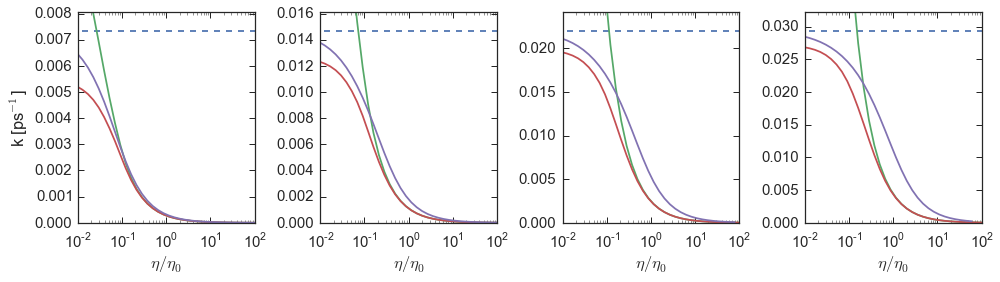

In [91]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, kKZ[i,:])
    ax[i].plot(scaling, kKZinter[i,:])
    ax[i].plot(scaling, kGH[i,:])
    ax[i].set_ylim(0,1.1*ktst[i])
    ax[i].set_xlim(1e-2,100)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
#   ax[i].set_yscale('log')
ax[0].set_ylabel(r'k [ps$^{-1}$]')
_  = plt.tight_layout()

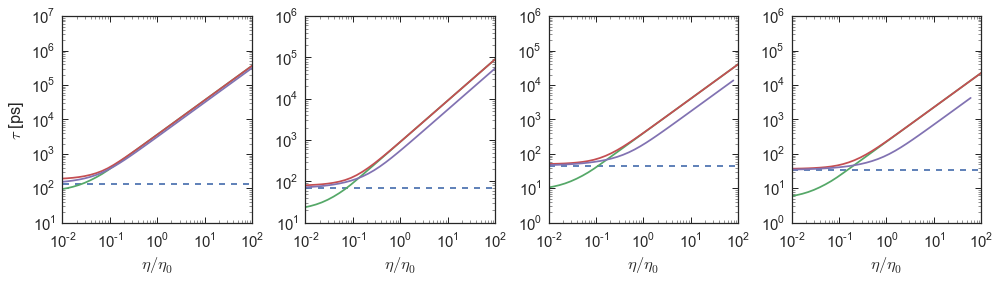

In [93]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, 1./ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, 1./kKZ[i,:])
    ax[i].plot(scaling, 1./kKZinter[i,:])
    ax[i].plot(scaling, 1./kGH[i,:])
    #ax[i].set_ylim(0,1.1*ktst[i])
    ax[i].set_xlim(1e-2,100)
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
ax[0].set_ylabel(r'$\tau$ [ps]')
_  = plt.tight_layout()

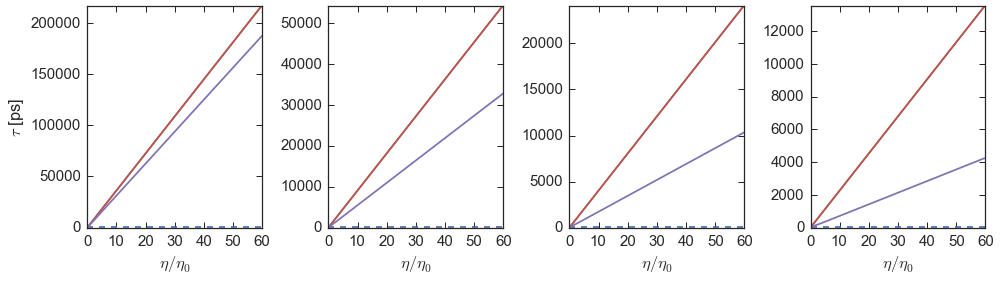

In [100]:
fig, ax = plt.subplots(1,4, figsize=(14,4))
for i in range(lprd):
    ax[i].plot(scaling, 1./ktst[i]*np.ones(lsc),'--')
    ax[i].plot(scaling, 1./kKZ[i,:])
    ax[i].plot(scaling, 1./kKZinter[i,:])
    ax[i].plot(scaling, 1./kGH[i,:])
    #ax[i].set_ylim(0,1.1*ktst[i])
    ax[i].set_xlim(1e-2,60)
    ax[i].set_ylim(1e-2,np.max(1./kKZ[i,:40]))
    ax[i].set_xlabel(r'$\eta/\eta_0$')
    #ax[i].set_xscale('log')
    #ax[i].set_yscale('log')
ax[0].set_ylabel(r'$\tau$ [ps]')
_  = plt.tight_layout()